# Nachbildung Mathematischer Operationen durch ML-Modelle

## 1. Erstellung der Datensätze

## 1.1 Trainingsdaten

In [4]:
# import numpy as np
# import pandas as pd

# N = 100000

# x1 = np.random.uniform(-10, 10, N)
# x2 = np.random.uniform(-10, 10, N)

# y = x1 + x2   # oder x1 * x2, x1 - x2

# data = pd.DataFrame({
#     "x1": x1,
#     "x2": x2,
#     "y": y
# })

# data.to_csv("addition_dataset.csv", index=False)


## 1.2 Generalisierungsdatensätze

In [5]:
# import numpy as np
# import pandas as pd

# N_gen = 100_000

# # Neuer Wertebereich (nicht im Training enthalten)
# x1_gen = np.random.uniform(10, 20, N_gen)
# x2_gen = np.random.uniform(10, 20, N_gen)

# y_gen = x1_gen * x2_gen   # oder * , -

# generalization_data = pd.DataFrame({
#     "x1": x1_gen,
#     "x2": x2_gen,
#     "y": y_gen
# })

# generalization_data.to_csv("multiplication_gen_dataset.csv", index=False)

# 2. SVM 

In [22]:
# =========================
# Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# =========================
# Global evaluation setup
# =========================

RANDOM_STATE = 42
CV_SPLITS = 5

cv = KFold(
    n_splits=CV_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

# =========================
# Results DataFrame
# =========================

results = pd.DataFrame(columns=[
    "model",
    "operator",
    "dataset_type",   # cv | test | generalization
    "mse",
    "mae",
    "rmse",
    "relative_error",
    "mape",
    "mse_std"         # only used for CV
])

# =========================
# Logging function
# =========================

def log_results(results_df, model_name, operator, dataset_type, y_true, y_pred, mse_std=np.nan):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    relative_error = np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + 1e-8))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    new_row = {
        "model": model_name,
        "operator": operator,
        "dataset_type": dataset_type,
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "relative_error": relative_error,
        "mape": mape,
        "mse_std": mse_std
    }

    return pd.concat(
        [results_df, pd.DataFrame([new_row])],
        ignore_index=True
    )


## 2.1 Addition

In [ ]:
# Load the dataset
data = pd.read_csv("addition_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model
svr_lin = SVR(kernel="linear", C=10, epsilon=0.01)

# -------------------------
# Cross-Validation (NEW)
# -------------------------
cv_mse = -cross_val_score(
    svr_lin,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "SVR",
    "operator": "addition",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# -------------------------
# Final training
# -------------------------
svr_lin.fit(X_train, y_train)

# Test prediction
y_pred = svr_lin.predict(X_test)

results = log_results(
    results,
    "SVR",
    "addition",
    "test",
    y_test,
    y_pred
)


In [ ]:
# Generalization Test (Extrapolation)
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

# IMPORTANT: use scaler fitted on training data
X_gen = scaler.transform(X_gen)

# Prediction with final trained model
y_pred_gen = svr_lin.predict(X_gen)

results = log_results(
    results,
    "SVR",
    "addition",
    "generalization",
    y_gen,
    y_pred_gen
)


In [25]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN


## 2.2 Multiplikation - rbf-Kernel

In [ ]:
# Load the dataset
data = pd.read_csv("multiplication_dataset.csv")

# Optionales Subsampling (ok für Rechenzeit, methodisch sauber)
data = data.sample(n=20000, random_state=42)

X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling (fit NUR auf Trainingsdaten)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------------
# Model definition
# -------------------------
svr_rbf = SVR(
    kernel="rbf",
    C=10,
    gamma="scale",
    epsilon=0.01
)

# -------------------------
# Cross-Validation (NEU)
# -------------------------
cv_mse = -cross_val_score(
    svr_rbf,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "SVR",
    "operator": "multiplication",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# -------------------------
# Final training
# -------------------------
svr_rbf.fit(X_train, y_train)

# -------------------------
# Test prediction (Interpolation)
# -------------------------
y_pred = svr_rbf.predict(X_test)

results = log_results(
    results,
    "SVR",
    "multiplication",
    "test",
    y_test,
    y_pred
)

# -------------------------
# Model info (optional)
# -------------------------
print("C:", svr_rbf.C)
print("Epsilon:", svr_rbf.epsilon)
print("Kernel:", svr_rbf.kernel)
print("Gamma:", svr_rbf.gamma if hasattr(svr_rbf, "gamma") else None)


C: 10
Epsilon: 0.01
Kernel: rbf
Gamma: scale


In [ ]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = svr_rbf.predict(X_gen)

results = log_results(results, "SVR", "multiplication", "generalization", y_gen, y_pred_gen)


In [28]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,0.042259,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,0.030965,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,29867.831134,148.789214,172.823121,0.601676,60.167591,NaN


# 3. Entscheidungsbäume & Random Forests

## 3.1 Addition Entscheidungsbäume

In [32]:
# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Modelldefinition
# -------------------------
tree_addition = DecisionTreeRegressor(
    max_depth=10,
    random_state=42
)

# -------------------------
# Cross-Validation (NEU)
# -------------------------
cv_mse = -cross_val_score(
    tree_addition,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "tree",
    "operator": "addition",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# -------------------------
# Finales Training
# -------------------------
tree_addition.fit(X_train, y_train)

# -------------------------
# Test (Interpolation)
# -------------------------
y_pred = tree_addition.predict(X_test)

results = log_results(
    results,
    "tree",
    "addition",
    "test",
    y_test,
    y_pred
)

# Optional: R²
r2 = r2_score(y_test, y_pred)
print(f"R² (Test): {r2:.4f}")


R² (Test): 0.9989


In [33]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_addition.predict(X_gen)

results = log_results(results, "tree", "addition", "generalization", y_gen, y_pred_gen)

In [34]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,0.042259,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,0.030965,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,29867.831134,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,203.960118,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,0.075366,NaN,0.274529,NaN,NaN,0.000677


## 3.2 Entscheidungsbaum - Multiplikation

In [39]:

# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entscheidungsbaum (Regression)
tree_multi = DecisionTreeRegressor(
    max_depth=10,          # Begrenzung gegen Overfitting
    random_state=42
)
cv_mse = -cross_val_score(
    tree_multi,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "tree",
    "operator": "multiplication",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# Training
tree_multi.fit(X_train, y_train)

# Vorhersage
y_pred = tree_multi.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)


print(f"R²: {r2:.4f}")

results = log_results(results, "tree", "multiplication", "test", y_test, y_pred)


R²: 0.9939


In [40]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_multi.predict(X_gen)

results = log_results(results, "tree", "multiplication", "generalization", y_gen, y_pred_gen)

/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [41]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,0.042259,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,0.030965,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,29867.831134,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,203.960118,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,0.075366,NaN,0.274529,NaN,NaN,0.000677


## 3.3 Random Forest - Additon

In [42]:
# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Modelldefinition
# -------------------------
forest_add = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# -------------------------
# Cross-Validation (NEU)
# -------------------------
cv_mse = -cross_val_score(
    forest_add,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "forest",
    "operator": "addition",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# -------------------------
# Finales Training
# -------------------------
forest_add.fit(X_train, y_train)

# -------------------------
# Test (Interpolation)
# -------------------------
y_pred = forest_add.predict(X_test)

results = log_results(
    results,
    "forest",
    "addition",
    "test",
    y_test,
    y_pred
)

# Optional: R²
r2 = r2_score(y_test, y_pred)
print(f"R² (Test): {r2:.4f}")


R² (Test): 0.9999


In [43]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_add.predict(X_gen)

results = log_results(results, "forest", "addition", "generalization", y_gen, y_pred_gen)

In [44]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,0.042259,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,0.030965,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,29867.831134,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,203.960118,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,0.075366,NaN,0.274529,NaN,NaN,0.000677


## 3.4 Random Forest - Multiplikation

In [ ]:
# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest mit Bagging
forest_mul = RandomForestRegressor(
    n_estimators=200,      # Anzahl Bäume
    max_depth=10,          # Begrenzung der Baumtiefe
    bootstrap=True,        # Bagging (Standard, hier explizit)
    random_state=42,
    n_jobs=-1
)

# -------------------------
# Cross-Validation (NEU)
# -------------------------
cv_mse = -cross_val_score(
    forest_mul,
    X_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=cv
)

results.loc[len(results)] = {
    "model": "forest",
    "operator": "multiplication",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# Training
forest_mul.fit(X_train, y_train)

# Vorhersage
y_pred = forest_mul.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

results = log_results(results, "forest", "multiplication", "test", y_test, y_pred)

Mean Squared Error: 4.211337741312613
Mean Absolute Error: 1.356066506751319
Mean Relative Error: 0.24003553792986318
R²: 0.9962


In [46]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_mul.predict(X_gen)

results = log_results(results, "forest", "multiplication", "generalization", y_gen, y_pred_gen)

/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [47]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,0.000024,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,0.000017,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,0.000232,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,0.042259,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,0.030965,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,29867.831134,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,203.960118,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,0.075366,NaN,0.274529,NaN,NaN,0.000677


# 4. Neuronale Netze

In [48]:
def build_nn():
    model = Sequential([
        Dense(32, activation="relu", input_shape=(2,)),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )
    return model


## 4.1 NN - Addition

In [49]:
# Datensatz laden
data = pd.read_csv("addition_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# Cross-Validation (NEU)
# =========================
cv_mse = []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    nn = build_nn()
    nn.fit(
        X_tr,
        y_tr,
        epochs=50,
        batch_size=128,
        verbose=0
    )

    y_val_pred = nn.predict(X_val).flatten()
    mse = mean_squared_error(y_val, y_val_pred)
    cv_mse.append(mse)

cv_mse = np.array(cv_mse)

results.loc[len(results)] = {
    "model": "neural_network",
    "operator": "addition",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# =========================
# Finales Training
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = build_nn()
model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=128,
    verbose=1
)

# =========================
# Test (Interpolation)
# =========================
y_pred = model.predict(X_test_scaled).flatten()

results = log_results(
    results,
    "neural_network",
    "addition",
    "test",
    y_test,
    y_pred
)
# Optional: R²
r2 = r2_score(y_test, y_pred)
print(f"R² (Test): {r2:.4f}")

/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
Epoch 1/50


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - loss: 9.2652 
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.0526
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0049
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 0.0018
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - loss: 0.0011
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - loss: 7.9806e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 5.8018e-04
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 4.1223e-04
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - loss: 2.8994e-04
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 2.0102e-04
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 1.3924e-04
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step - loss: 9.2967e-05
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 6.6720e-05
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 5.6771e-05
Epo

In [50]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = model.predict(X_gen).flatten()

results = log_results(results, "neural_network", "addition", "generalization", y_gen, y_pred_gen)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 192us/step


In [51]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,2.371643e-05,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,1.732200e-05,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,2.316643e-04,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,4.225906e-02,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,3.096484e-02,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,2.986783e+04,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708e+00,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265e+00,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,2.039601e+02,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,7.536624e-02,NaN,0.274529,NaN,NaN,0.000677


## 4.2 NN - Multiplikation

In [52]:
# Datensatz laden
data = pd.read_csv("multiplication_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# Cross-Validation (NEU)
# =========================
cv_mse = []

for train_idx, val_idx in cv.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)

    nn = build_nn()
    nn.fit(
        X_tr,
        y_tr,
        epochs=50,
        batch_size=128,
        verbose=0
    )

    y_val_pred = nn.predict(X_val).flatten()
    mse = mean_squared_error(y_val, y_val_pred)
    cv_mse.append(mse)

cv_mse = np.array(cv_mse)

results.loc[len(results)] = {
    "model": "neural_network",
    "operator": "multiplication",
    "dataset_type": "cv",
    "mse": cv_mse.mean(),
    "mae": np.nan,
    "rmse": np.sqrt(cv_mse.mean()),
    "relative_error": np.nan,
    "mape": np.nan,
    "mse_std": cv_mse.std()
}

# =========================
# Finales Training
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_mul = build_nn()
model_mul.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=128,
    verbose=1
)

# =========================
# Test (Interpolation)
# =========================
y_pred = model_mul.predict(X_test_scaled).flatten()

results = log_results(
    results,
    "neural_network",
    "multiplication",
    "test",
    y_test,
    y_pred
)
# Optional: R²
r2 = r2_score(y_test, y_pred)
print(f"R² (Test): {r2:.4f}")

/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
Epoch 1/50


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step - loss: 403.4565
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 17.3689
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 5.4972
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 1.8216
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 0.8688
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 0.5289
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 0.3639
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 0.2699
Epoch 9/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 0.2221
Epoch 10/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 0.1879
Epoch 11/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 0.1679
Epoch 12/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.1493
Epoch 13/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 0.1347
Epoch 14/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step - loss: 0.1272
Epoch 15/50
625/625 ━━━━━━━━━━━━━━━━━

In [53]:
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = model_mul.predict(X_gen).flatten()

results = log_results(results, "neural_network", "multiplication", "generalization", y_gen, y_pred_gen)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 208us/step


In [54]:
results

,model,operator,dataset_type,mse,mae,rmse,relative_error,mape,mse_std
0,SVR-linear,addition,cv,2.371643e-05,NaN,0.004870,NaN,NaN,0.000008
1,SVR-linear,addition,test,1.732200e-05,0.003425,0.004162,0.001302,0.130188,NaN
2,SVR-linear,addition,generalization,2.316643e-04,0.015077,0.015221,0.000503,0.050290,NaN
3,SVR-rbf,multiplication,cv,4.225906e-02,NaN,0.205570,NaN,NaN,0.006143
4,SVR-rbf,multiplication,test,3.096484e-02,0.046582,0.175968,0.002191,0.219087,NaN
5,SVR-rbf,multiplication,generalization,2.986783e+04,148.789214,172.823121,0.601676,60.167591,NaN
6,tree,addition,cv,2.531708e+00,NaN,1.591134,NaN,NaN,0.028154
7,tree,addition,test,2.547265e+00,1.335685,1.596015,1.717641,171.765300,NaN
8,tree,addition,generalization,2.039601e+02,13.684838,14.281461,0.445906,44.590551,NaN
9,tree,addition,cv,7.536624e-02,NaN,0.274529,NaN,NaN,0.000677


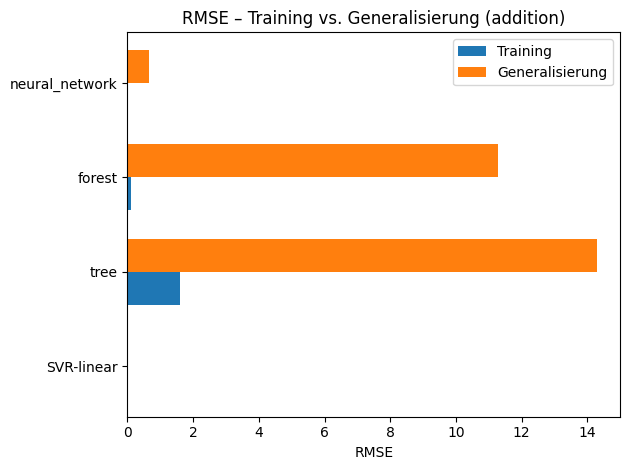

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Filter: Operator und Metrik
operator = "addition"
metric = "rmse"

subset = results[
    (results["operator"] == operator) &
    (results["dataset_type"].isin(["test", "generalization"]))
]

models = subset["model"].unique()
y_pos = np.arange(len(models))
bar_height = 0.35

cv_values = []
train_values = []
gen_values = []

for model in models:
    train_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "test")
        ][metric].values[0]
    )
    gen_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "generalization")
        ][metric].values[0]
    )

plt.figure()
plt.barh(y_pos - bar_height/2, train_values, height=bar_height, label="Training")
plt.barh(y_pos + bar_height/2, gen_values, height=bar_height, label="Generalisierung")

plt.yticks(y_pos, models)
plt.xlabel(metric.upper())
plt.title(f"{metric.upper()} – Training vs. Generalisierung ({operator})")
plt.legend()
plt.tight_layout()
plt.show()


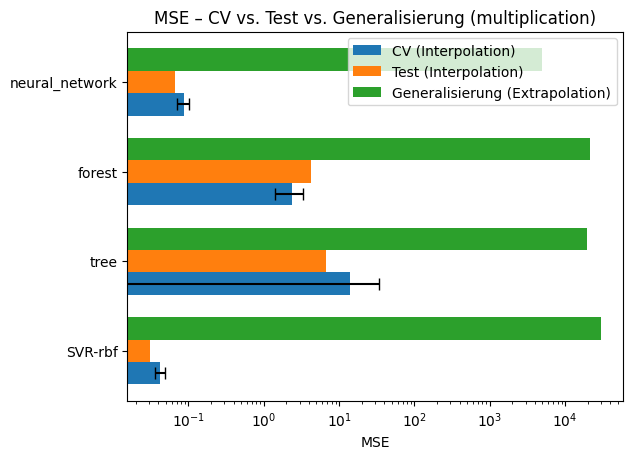

In [60]:
import matplotlib.pyplot as plt
import numpy as np

operator = "multiplication"
metric = "mse"

subset = results[
    (results["operator"] == operator) &
    (results["dataset_type"].isin(["cv", "test", "generalization"]))
]

models = subset["model"].unique()
y_pos = np.arange(len(models))
bar_height = 0.25

cv_values = []
cv_std = []
test_values = []
gen_values = []

for model in models:
    # CV
    cv_row = subset[
        (subset["model"] == model) &
        (subset["dataset_type"] == "cv")
    ]
    cv_values.append(cv_row[metric].values[0])
    cv_std.append(cv_row["mse_std"].values[0])

    # Test
    test_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "test")
        ][metric].values[0]
    )

    # Generalisierung
    gen_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "generalization")
        ][metric].values[0]
    )

plt.figure()
plt.barh(y_pos - bar_height, cv_values, height=bar_height,
         xerr=cv_std, label="CV (Interpolation)", capsize=4)
plt.barh(y_pos, test_values, height=bar_height,
         label="Test (Interpolation)")
plt.barh(y_pos + bar_height, gen_values, height=bar_height,
         label="Generalisierung (Extrapolation)")

plt.yticks(y_pos, models)
plt.xlabel(metric.upper())
plt.title(f"{metric.upper()} – CV vs. Test vs. Generalisierung ({operator})")
plt.legend()
plt.xscale("log")


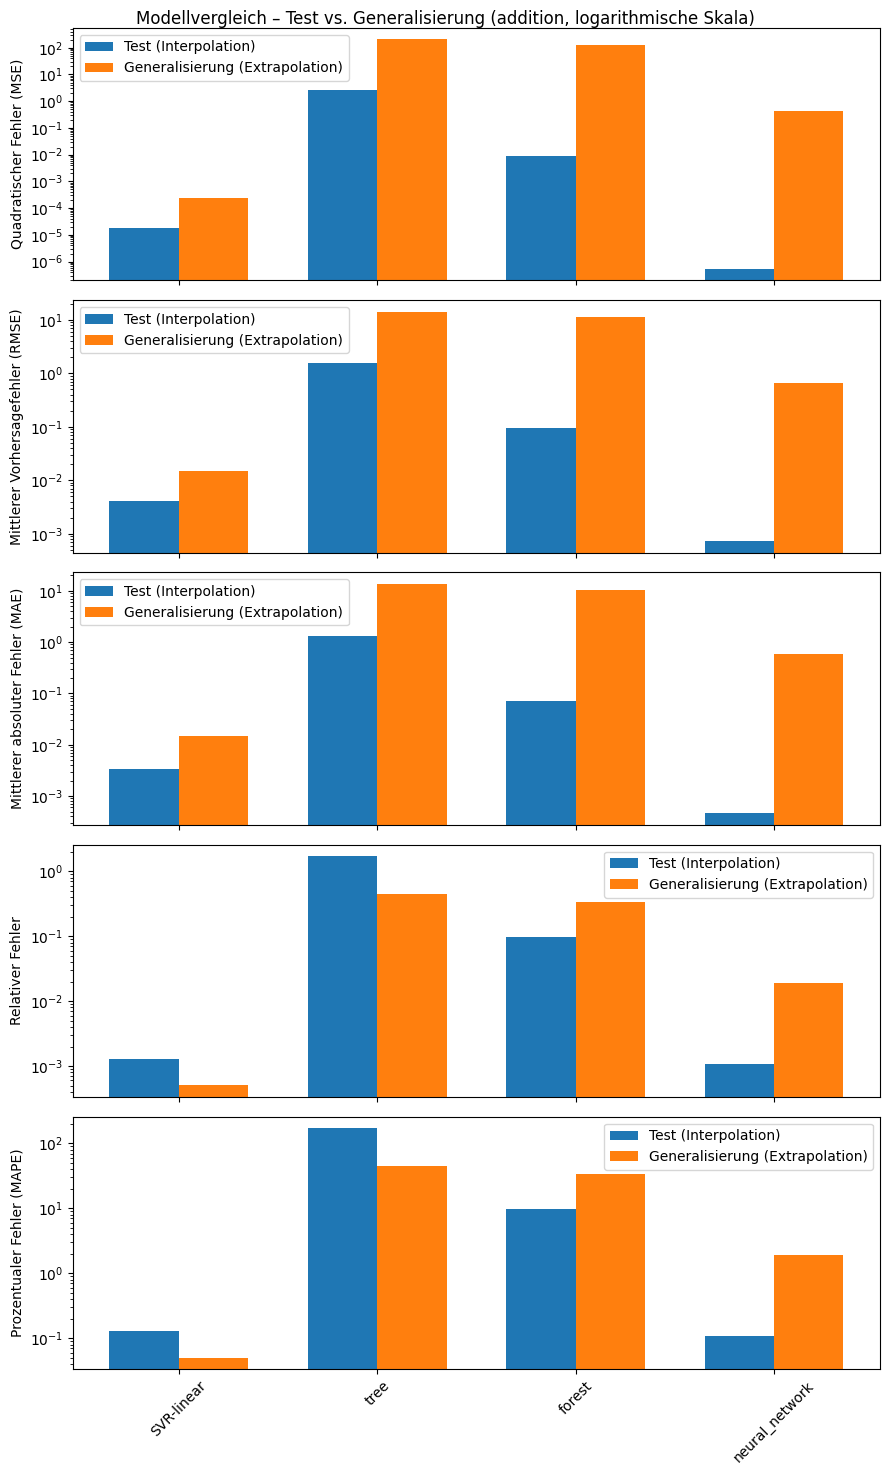

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# Einstellungen
# =========================
operator = "addition"   # oder "multiplication"

metrics = ["mse", "rmse", "mae", "relative_error", "mape"]
dataset_types = ["test", "generalization"]

# Verständliche Achsenlabels
metric_labels = {
    "mse": "Quadratischer Fehler (MSE)",
    "rmse": "Mittlerer Vorhersagefehler (RMSE)",
    "mae": "Mittlerer absoluter Fehler (MAE)",
    "relative_error": "Relativer Fehler",
    "mape": "Prozentualer Fehler (MAPE)"
}

# =========================
# Daten filtern
# =========================
subset = results[
    (results["operator"] == operator) &
    (results["dataset_type"].isin(dataset_types))
]

models = subset["model"].unique()
x = np.arange(len(models))
bar_width = 0.35

# =========================
# Plot
# =========================
fig, axes = plt.subplots(
    len(metrics),
    1,
    figsize=(9, 3 * len(metrics)),
    sharex=True
)

for i, metric in enumerate(metrics):
    ax = axes[i]

    test_vals = []
    gen_vals = []

    for model in models:
        test_row = subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "test")
        ][metric]

        gen_row = subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "generalization")
        ][metric]

        # robust gegen fehlende Kombinationen
        test_vals.append(test_row.values[0] if len(test_row) else np.nan)
        gen_vals.append(gen_row.values[0] if len(gen_row) else np.nan)

    ax.bar(
        x - bar_width / 2,
        test_vals,
        bar_width,
        label="Test (Interpolation)"
    )
    ax.bar(
        x + bar_width / 2,
        gen_vals,
        bar_width,
        label="Generalisierung (Extrapolation)"
    )

    # Verständliche y-Achse
    ax.set_ylabel(metric_labels[metric])
    ax.set_yscale("log")   # extrem wichtig bei deinen Ergebnissen
    ax.legend()

# =========================
# Gemeinsame x-Achse
# =========================
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(models, rotation=45)

fig.suptitle(
    f"Modellvergleich – Test vs. Generalisierung ({operator}, logarithmische Skala)",
    y=0.98
)

plt.tight_layout()
plt.show()


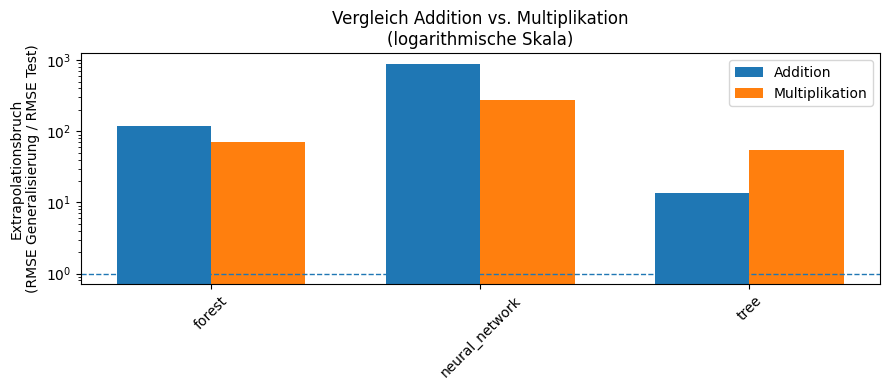

In [70]:
import matplotlib.pyplot as plt
import numpy as np

metric = "rmse"
operators = ["addition", "multiplication"]

ratios = {}
models_common = None

for op in operators:
    subset = results[
        (results["operator"] == op) &
        (results["dataset_type"].isin(["test", "generalization"]))
    ]

    pivot = subset.pivot_table(
        index="model",
        columns="dataset_type",
        values=metric,
        aggfunc="mean"   # <<< DAS ist der Fix
    ).dropna()

    pivot["ratio"] = pivot["generalization"] / pivot["test"]
    ratios[op] = pivot["ratio"]

    if models_common is None:
        models_common = pivot.index
    else:
        models_common = models_common.intersection(pivot.index)

models = list(models_common)

add_ratios = ratios["addition"].loc[models]
mul_ratios = ratios["multiplication"].loc[models]

x = np.arange(len(models))
bar_width = 0.35

# =========================
# Plot
# =========================
plt.figure(figsize=(9, 4))

plt.bar(x - bar_width/2, add_ratios, bar_width, label="Addition")
plt.bar(x + bar_width/2, mul_ratios, bar_width, label="Multiplikation")

plt.axhline(1, linestyle="--", linewidth=1)

plt.yscale("log")
plt.ylabel("Extrapolationsbruch\n(RMSE Generalisierung / RMSE Test)")
plt.xticks(x, models, rotation=45)
plt.title("Vergleich Addition vs. Multiplikation\n(logarithmische Skala)")
plt.legend()
plt.tight_layout()
plt.show()
